In [38]:
from simulation.simulator import Simulator

In [39]:
def diffeq_lorenz_system(t, z, args):
    """
    Coupled differential equations representing the Lorenz system.
    """
    sigma, rho, beta = args
    x1, x2, x3 = z
    dx1dt = sigma * (x2 - x1)
    dx2dt = x1 * (rho - x3) - x2
    dx3dt = x1 * x2 - beta * x3
    return [dx1dt, dx2dt, dx3dt]

In [40]:
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

ics = []
for i in range(0, 10000):
    x1_0 = 5.0 + 0.00001 * i
    x2_0 = 1.0
    x3_0 = 1.0
    ics.append([x1_0, x2_0, x3_0])

In [41]:
scipy_sim = Simulator("scipy")

In [42]:
# scipy_sim.cpu_sequential_solve_ics(
#     ics, diffeq_lorenz_system, [sigma, rho, beta], 0.0, 100.0, 0.01
# )

In [43]:
# TODO: log each IC as well, they're being appended out of order so the plots don't make sense
scipy_sim.cpu_parallel_solve_ics(
    ics=ics,
    num_processes=10,
    diffeq_func=diffeq_lorenz_system,
    args=[sigma, rho, beta],
    ti=0.0,
    tf=100.0,
    dt=0.01,
)

Benchmarked time = 69.14903259277344
Function benchmarked was: <function Simulator.cpu_parallel_solve_ics at 0x75f58e593130>


In [44]:
scipy_sim.sols[0]["t"]

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01])

cpu_serial_solve_ics(ics, scipy_sim, diffeq_lorenz_system, [])

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean


# Function to compute pairwise distances between the first trajectory and others
def compute_distances(first_solution, all_solutions):
    time_steps = len(first_solution["t"])
    num_solutions = len(all_solutions)

    # Initialize an array to hold the distances over time
    distances = np.zeros((num_solutions, time_steps))

    # Loop through all solutions and compute distance at each time step
    for i, sol in enumerate(all_solutions):
        for t in range(time_steps):
            # Compute Euclidean distance between the first solution and the current solution
            distances[i, t] = euclidean(
                (
                    first_solution["y"][0][t],
                    first_solution["y"][1][t],
                    first_solution["y"][2][t],
                ),
                (sol["y"][0][t], sol["y"][1][t], sol["y"][2][t]),
            )

    return distances


# Get the first solution to use as a reference
first_solution = scipy_sim.sols[0]

# Compute the distances between the first solution and all other solutions
distances = compute_distances(first_solution, scipy_sim.sols)

# Plot the distances for each solution
plt.figure(figsize=(10, 6))
for i in range(
    1, len(scipy_sim.sols)
):  # Start from 1 to skip the first initial condition (distance is zero)
    print(first_solution["t"])
    print(distances[i])
    plt.plot(first_solution["t"], distances[i], label=f"Solution {i}")

plt.title("Euclidean Distance Between First Initial Condition and Others")
plt.xlabel("Time")
plt.ylabel("Distance")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

[0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]
[5.00000000e-03 4.76387840e-03 4.98383580e-03 ... 1.19653002e+01
 1.23552960e+01 1.28180806e+01]
[0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]
[ 0.0125      0.0119097   0.01245959 ... 11.53134294 11.55147073
 11.59296684]
[0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]
[7.50000000e-03 7.14581768e-03 7.47575443e-03 ... 2.37176184e+01
 2.46401568e+01 2.57083201e+01]
[0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]
[2.50000000e-03 2.38193917e-03 2.49191765e-03 ... 1.18686871e+01
 1.22853208e+01 1.27720388e+01]
[0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]
[0.005      0.00476388 0.00498383 ... 3.17148193 3.17092917 3.18862762]
[0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]
[2.50000000e-03 2.38193912e-03 2.49191716e-03 ... 1.13418661e+01
 1.11138654e+01 1.09106284e+01]
[0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]

/tmp/ipykernel_28543/1171528278.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


ValueError: Image size of 995x209476 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

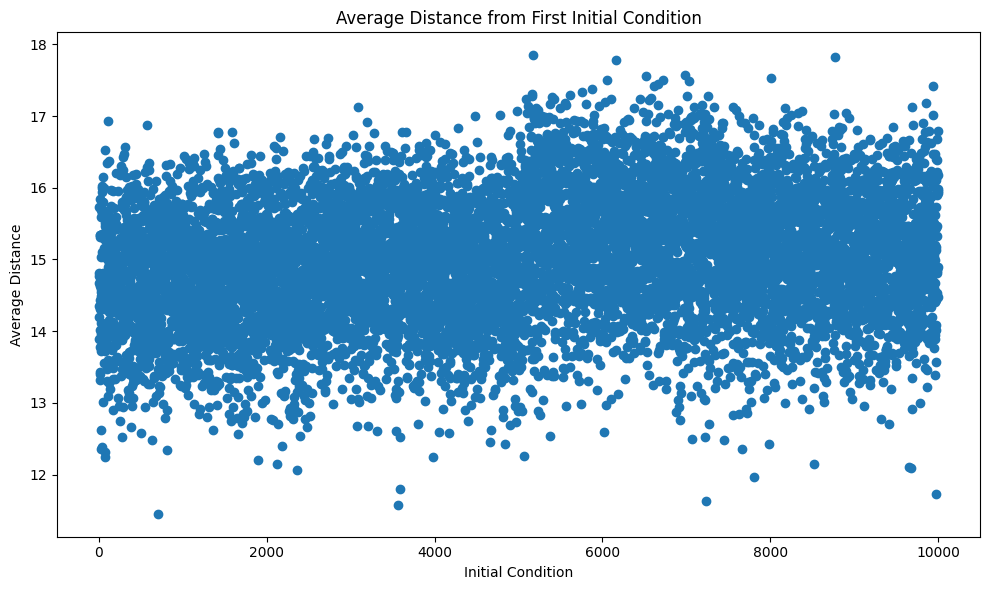

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the average distance for each solution (excluding the first solution itself)
average_distances = np.average(
    distances[1:], axis=1
)  # Skip the first solution (index 0)

# Create a list of initial condition indices (starting from 1, as we're comparing to the first initial condition)
initial_conditions = np.arange(1, len(scipy_sim.sols))

# Plot average distance from the first initial condition for each solution
plt.figure(figsize=(10, 6))
plt.scatter(initial_conditions, average_distances)

# Add labels and title
plt.title("Average Distance from First Initial Condition")
plt.xlabel("Initial Condition")
plt.ylabel("Average Distance")
plt.tight_layout()
plt.show()